# Limpeza e Análise Exploratória de Dados
## Hackathon Terra Signal - Previsão de Churn

---

**Objetivo:** Limpar, analisar e preparar os dados para modelagem de churn

**Dataset:** 
- `history.csv`: 5.912 linhas (treino)
- `inference.csv`: 1.461 linhas (teste)

**Features:** 23 colunas 

---

## 1. Imports e Configurações

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from scipy.stats import mannwhitneyu
from wordcloud import WordCloud

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


##  2. Carregamento dos Dados

In [68]:
df_train = pd.read_csv('history.csv')
df_inference = pd.read_csv('inference.csv')

print("INFORMAÇÕES DOS DATASETS\n")
print(f"Training data shape: {df_train.shape}")
print(f"Inference data shape: {df_inference.shape}")
print(f"\nColunas ({len(df_train.columns)}): {list(df_train.columns)}")

df_train.head().transpose()

INFORMAÇÕES DOS DATASETS

Training data shape: (5634, 23)
Inference data shape: (1409, 22)

Colunas (23): ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'CustomerFeedback', 'MonthlyIncome']


,0,1,2,3,4
customerID,4578-PHJYZ,6289-CPNLD,2682-KEVRP,5697-GOMBF,9717-QEBGU
gender,Male,Male,Female,Female,Male
SeniorCitizen,0,0,1,1,0
Partner,Yes,Yes,No,Yes,No
Dependents,Yes,Yes,No,Yes,No
tenure,52,33,22,28,2
PhoneService,Yes,Yes,Yes,No,Yes
MultipleLines,No,No,No,No phone service,No
InternetService,DSL,DSL,No,DSL,Fiber optic
OnlineSecurity,No,No,No internet service,No,No


## 3. Análise inicial de qualidade e integridade de dados

In [69]:
df = df_train

print("INFORMAÇÕES GERAIS:\n")
print(df.info())


print("\n VALORES AUSENTES:\n")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage (%)': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

print("\n TIPOS DE DADOS:\n")
print(df.dtypes.value_counts())

print("\n DUPLICATAS:\n")
duplicates = df.duplicated().sum()
duplicate_ids = df['customerID'].duplicated().sum() if 'customerID' in df.columns else 0
print(f"Linhas completamente duplicadas: {duplicates}")
print(f"customerIDs duplicados: {duplicate_ids}")

print("\n ESTATÍSTICAS NUMÉRICAS:\n")
print(df.describe().T)

print("\n CARDINALIDADE DAS CATEGÓRICAS:\n")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"{col:25s}: {n_unique:5d} valores únicos")
    if n_unique <= 10:
        print(f"    {df[col].value_counts().to_dict()}")


INFORMAÇÕES GERAIS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   object 
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  563

##  4. Limpeza de Dados

In [70]:
def clean_data(df, is_training=True):
    df_clean = df.copy()
    
    # Convertendo o Tenure para um valor numérico 
    if 'tenure' in df_clean.columns:
        df_clean['tenure'] = pd.to_numeric(df_clean['tenure'], errors='coerce')
        tenure_missing = df_clean['tenure'].isnull().sum()
        if tenure_missing > 0:
            median_tenure = df_clean['tenure'].median()
            df_clean['tenure'] = df_clean['tenure'].fillna(median_tenure)
    
    # Tratando as TOTALCHARGES
    if 'TotalCharges' in df_clean.columns and df_clean['TotalCharges'].dtype == 'object':
        df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
        mask_missing = df_clean['TotalCharges'].isnull()
        if mask_missing.sum() > 0:
            df_clean.loc[mask_missing, 'TotalCharges'] = \
                df_clean.loc[mask_missing, 'tenure'] * df_clean.loc[mask_missing, 'MonthlyCharges']
    
    # Padronizando as strings para converter o yes/no para maiúsculo 
    string_cols = df_clean.select_dtypes(include=['object']).columns
    for col in string_cols:
        df_clean[col] = df_clean[col].str.strip()
        # Converter yes/no para Yes/No para padronizar
        df_clean[col] = df_clean[col].str.replace('yes', 'Yes', case=False)
        df_clean[col] = df_clean[col].str.replace('no', 'No', case=False)
       
    # Se não tem PhoneService, MultipleLines deve ser 'No phone service'
    if 'PhoneService' in df_clean.columns and 'MultipleLines' in df_clean.columns:
        inconsistent = (df_clean['PhoneService'] == 'No') & (df_clean['MultipleLines'] != 'No phone service')
        if inconsistent.sum() > 0:
            df_clean.loc[inconsistent, 'MultipleLines'] = 'No phone service'
    
    # Se não tem InternetService, features de internet devem ser 'No internet service'
    internet_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                         'TechSupport', 'StreamingTV', 'StreamingMovies']
    if 'InternetService' in df_clean.columns:
        no_internet_mask = df_clean['InternetService'] == 'No'
        for feature in internet_features:
            if feature in df_clean.columns:
                df_clean.loc[no_internet_mask, feature] = 'No internet service'
    
    # Tratando o customer feedback
    if 'CustomerFeedback' in df_clean.columns:
        missing_feedback = df_clean['CustomerFeedback'].isnull().sum()
        df_clean['CustomerFeedback'] = df_clean['CustomerFeedback'].fillna('No feedback provided')
    
    #Removendo duplicatas
    df_clean = df_clean.drop_duplicates()

    
    # Guardando o customerID antes de remover
    customer_ids = df_clean['customerID'].copy() if 'customerID' in df_clean.columns else None
    
    # Guardando o CustomerFeedback antes de remover (para análise NLP separada)
    feedback = df_clean['CustomerFeedback'].copy() if 'CustomerFeedback' in df_clean.columns else None
    
    # Guardando o  target (Churn) se for treino
    target = df_clean['Churn'].copy() if is_training and 'Churn' in df_clean.columns else None
    
    # Removendo colunas que não serão usadas na modelagem
    cols_to_drop = ['customerID', 'CustomerFeedback']
    if is_training:
        cols_to_drop.append('Churn')
    
    for col in cols_to_drop:
        if col in df_clean.columns:
            df_clean = df_clean.drop(columns=[col])
    
    # Convertendo SeniorCitizen para Yes/No se ainda for numérico
    if 'SeniorCitizen' in df_clean.columns:
        if df_clean['SeniorCitizen'].dtype != 'object':
            df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
    
    # Identificando as colunas binárias Yes/No para converter em 0/1
    binary_cols = []
    for col in df_clean.select_dtypes(include=['object']).columns:
        unique_vals = df_clean[col].unique()
        if len(unique_vals) == 2 and set(unique_vals) <= {'Yes', 'No'}:
            binary_cols.append(col)
    
    # Convertendo o Yes/No para 1/0
    for col in binary_cols:
        df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})
    
    
    # Identificando as colunas categóricas para fazer One-Hot Encoding
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    # Aplicando One-Hot Encoding
    if len(categorical_cols) > 0:
        df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
    
    # Adicionando de volta o target se for treino
    if target is not None:
        df_clean['Churn'] = target.map({'Yes': 1, 'No': 0}).values
    
    # Adicionando de volta customerID e CustomerFeedback para referência
    if customer_ids is not None:
        df_clean.insert(0, 'customerID', customer_ids.values)
    
    if feedback is not None:
        df_clean['CustomerFeedback'] = feedback.values
    
    # Verificação final
    if (is_training):
        print("\nVerificação final de dataset de treino:")
    else:
        print("\nVerificação final de dataset de teste:")
    remaining_nulls = df_clean.isnull().sum().sum()
    print(f"Valores nulos restantes: {remaining_nulls}")
    print(f"Tipos de dados: {df_clean.dtypes.value_counts().to_dict()}")
    print(f"Shape final: {df_clean.shape}")
    print(f"Dados prontos para modelagem de Machine Learning!")
    
    return df_clean


df_train_clean = clean_data(df_train, is_training=True)
df_inference_clean = clean_data(df_inference, is_training=False)


Verificação final de dataset de treino:
Valores nulos restantes: 278
Tipos de dados: {dtype('bool'): 22, dtype('int64'): 7, dtype('float64'): 3, dtype('O'): 2}
Shape final: (5634, 34)
Dados prontos para modelagem de Machine Learning!

Verificação final de dataset de teste:
Valores nulos restantes: 64
Tipos de dados: {dtype('bool'): 22, dtype('int64'): 6, dtype('float64'): 3, dtype('O'): 2}
Shape final: (1409, 33)
Dados prontos para modelagem de Machine Learning!


In [71]:
df_train_clean.head().transpose()

,0,1,2,3,4
customerID,4578-PHJYZ,6289-CPNLD,2682-KEVRP,5697-GOMBF,9717-QEBGU
SeniorCitizen,0,0,1,1,0
Partner,1,1,0,1,0
Dependents,1,1,0,1,0
tenure,52.0,33.0,22.0,28.0,2.0
PhoneService,1,1,1,0,1
PaperlessBilling,1,1,1,1,1
MonthlyCharges,68.75,73.9,20.05,35.9,70.3
TotalCharges,3482.85,2405.05,417.0,973.65,144.0
MonthlyIncome,6532,7634,3628,7851,1691


##  5. Análise da Variável Target (Churn)


 Distribuição:

0:  4130 (73.30%)
1:  1504 (26.70%)

 Classe minoritária: 26.70%
Dataset DESBALANCEADO! Considerar SMOTE ou class_weight


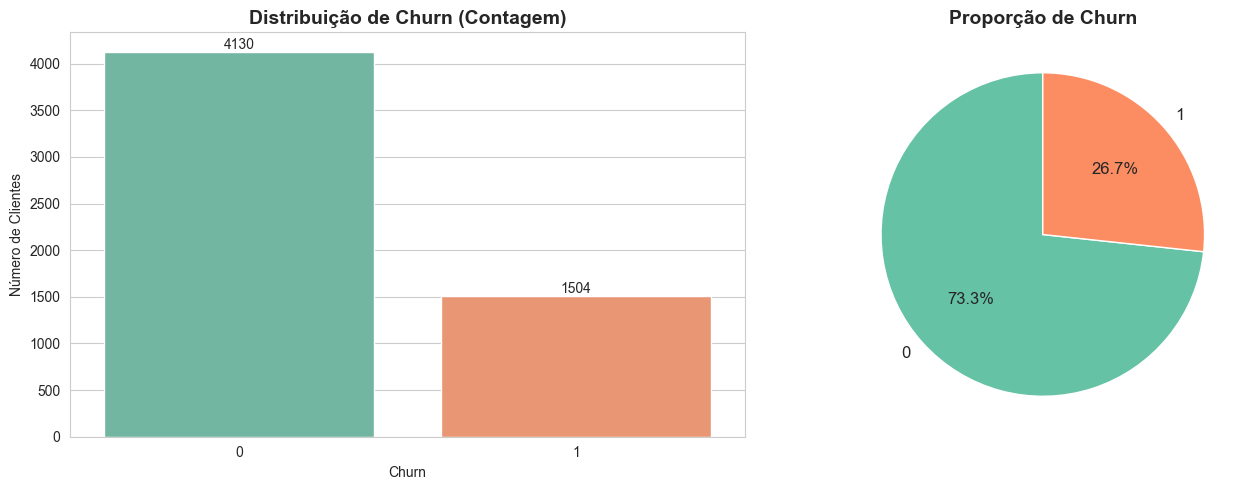

In [72]:
df = df_train_clean

churn_counts = df['Churn'].value_counts()
churn_props = df['Churn'].value_counts(normalize=True) * 100

print("\n Distribuição:\n")

for value in churn_counts.index:
    count = churn_counts[value]
    pct = churn_props[value]
    print(f"{value}: {count:5d} ({pct:5.2f}%)")    

minority_class_pct = min(churn_props.values)
print(f"\n Classe minoritária: {minority_class_pct:.2f}%")
if minority_class_pct < 30:
    print("Dataset DESBALANCEADO! Considerar SMOTE ou class_weight")
else:
    print("Dataset razoavelmente balanceado")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='Churn', palette='Set2', ax=axes[0])
axes[0].set_title('Distribuição de Churn (Contagem)', fontsize=14, weight='bold')
axes[0].set_ylabel('Número de Clientes')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')


colors = sns.color_palette('Set2')
axes[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[1].set_title('Proporção de Churn', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()



## 6. EDA - Análise Univariada (Features Numéricas)


 ANÁLISE DE FEATURES NUMÉRICAS

tenure:
  Média: 32.29
  Mediana: 29.00
  Desvio Padrão: 24.44
  Min: 0.00 | Max: 72.00
  Skewness: 0.24

MonthlyCharges:
  Média: 64.61
  Mediana: 70.30
  Desvio Padrão: 30.15
  Min: 18.40 | Max: 118.65
  Skewness: -0.21

TotalCharges:
  Média: 2271.88
  Mediana: 1390.72
  Desvio Padrão: 2253.78
  Min: 18.80 | Max: 8684.80
  Skewness: 0.97

MonthlyIncome:
  Média: 5104.88
  Mediana: 5079.50
  Desvio Padrão: 2839.23
  Min: 100.00 | Max: 9993.00
  Skewness: -0.01


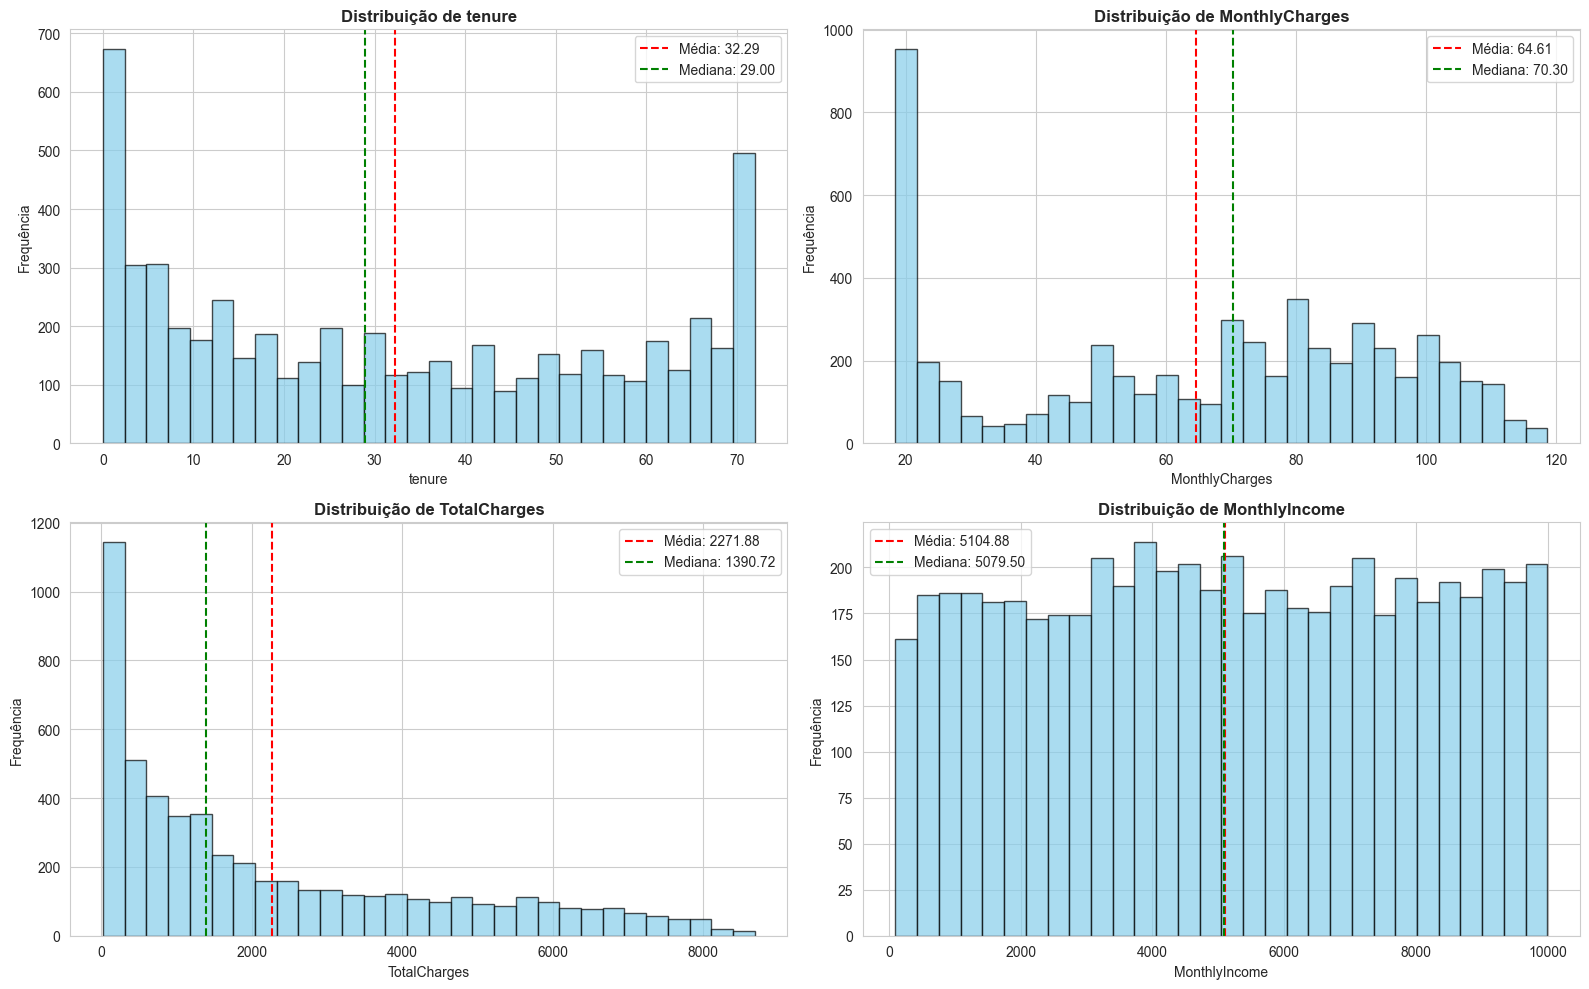


🔍 DETECÇÃO DE OUTLIERS
----------------------------------------------------------------------
tenure: 0 outliers detectados (0.00%)
MonthlyCharges: 0 outliers detectados (0.00%)
TotalCharges: 0 outliers detectados (0.00%)
MonthlyIncome: 0 outliers detectados (0.00%)


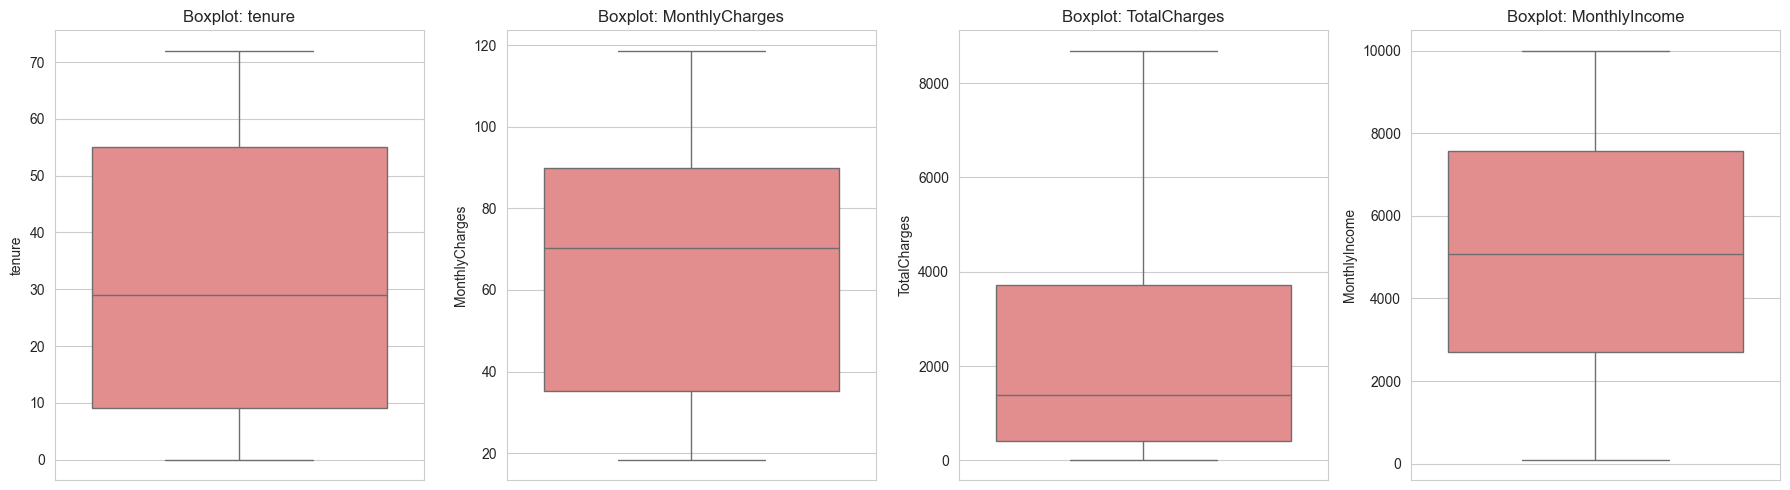

In [73]:
df = df_train_clean

print("\n ANÁLISE DE FEATURES NUMÉRICAS")


numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyIncome']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_title(f'Distribuição de {col}', fontsize=12, weight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label=f'Média: {df[col].mean():.2f}')
    axes[i].axvline(df[col].median(), color='green', linestyle='--', label=f'Mediana: {df[col].median():.2f}')
    axes[i].legend()
    
    print(f"\n{col}:")
    print(f"  Média: {df[col].mean():.2f}")
    print(f"  Mediana: {df[col].median():.2f}")
    print(f"  Desvio Padrão: {df[col].std():.2f}")
    print(f"  Min: {df[col].min():.2f} | Max: {df[col].max():.2f}")
    print(f"  Skewness: {df[col].skew():.2f}")

plt.tight_layout()
plt.show()

print("\n🔍 DETECÇÃO DE OUTLIERS")
print("-" * 70)

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot: {col}')
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]
    print(f"{col}: {len(outliers)} outliers detectados ({len(outliers)/len(df)*100:.2f}%)")

plt.tight_layout()
plt.show()



## 7. EDA - Análise Univariada (Features Categóricas)


 ANÁLISE DE FEATURES CATEGÓRICAS:


SeniorCitizen:
  No                       :  4706 (83.53%)
  Yes                      :   928 (16.47%)

Partner:
  No                       :  2907 (51.60%)
  Yes                      :  2727 (48.40%)

Dependents:
  No                       :  3949 (70.09%)
  Yes                      :  1685 (29.91%)

PhoneService:
  No                       :   563 ( 9.99%)
  Yes                      :  5071 (90.01%)

PaperlessBilling:
  No                       :  2307 (40.95%)
  Yes                      :  3327 (59.05%)

gender:
  Male                     :  2835 (50.32%)
  gender                   :  2799 (49.68%)

MultipleLines:
  No phone service         :   563 ( 9.99%)
  Yes                      :  2367 (42.01%)
  MultipleLines            :  2704 (47.99%)

InternetService:
  Fiber optic              :  2477 (43.97%)
  No                       :  1233 (21.88%)
  InternetService          :  1924 (34.15%)

OnlineSecurity:
  No internet service      :  1233 (21.

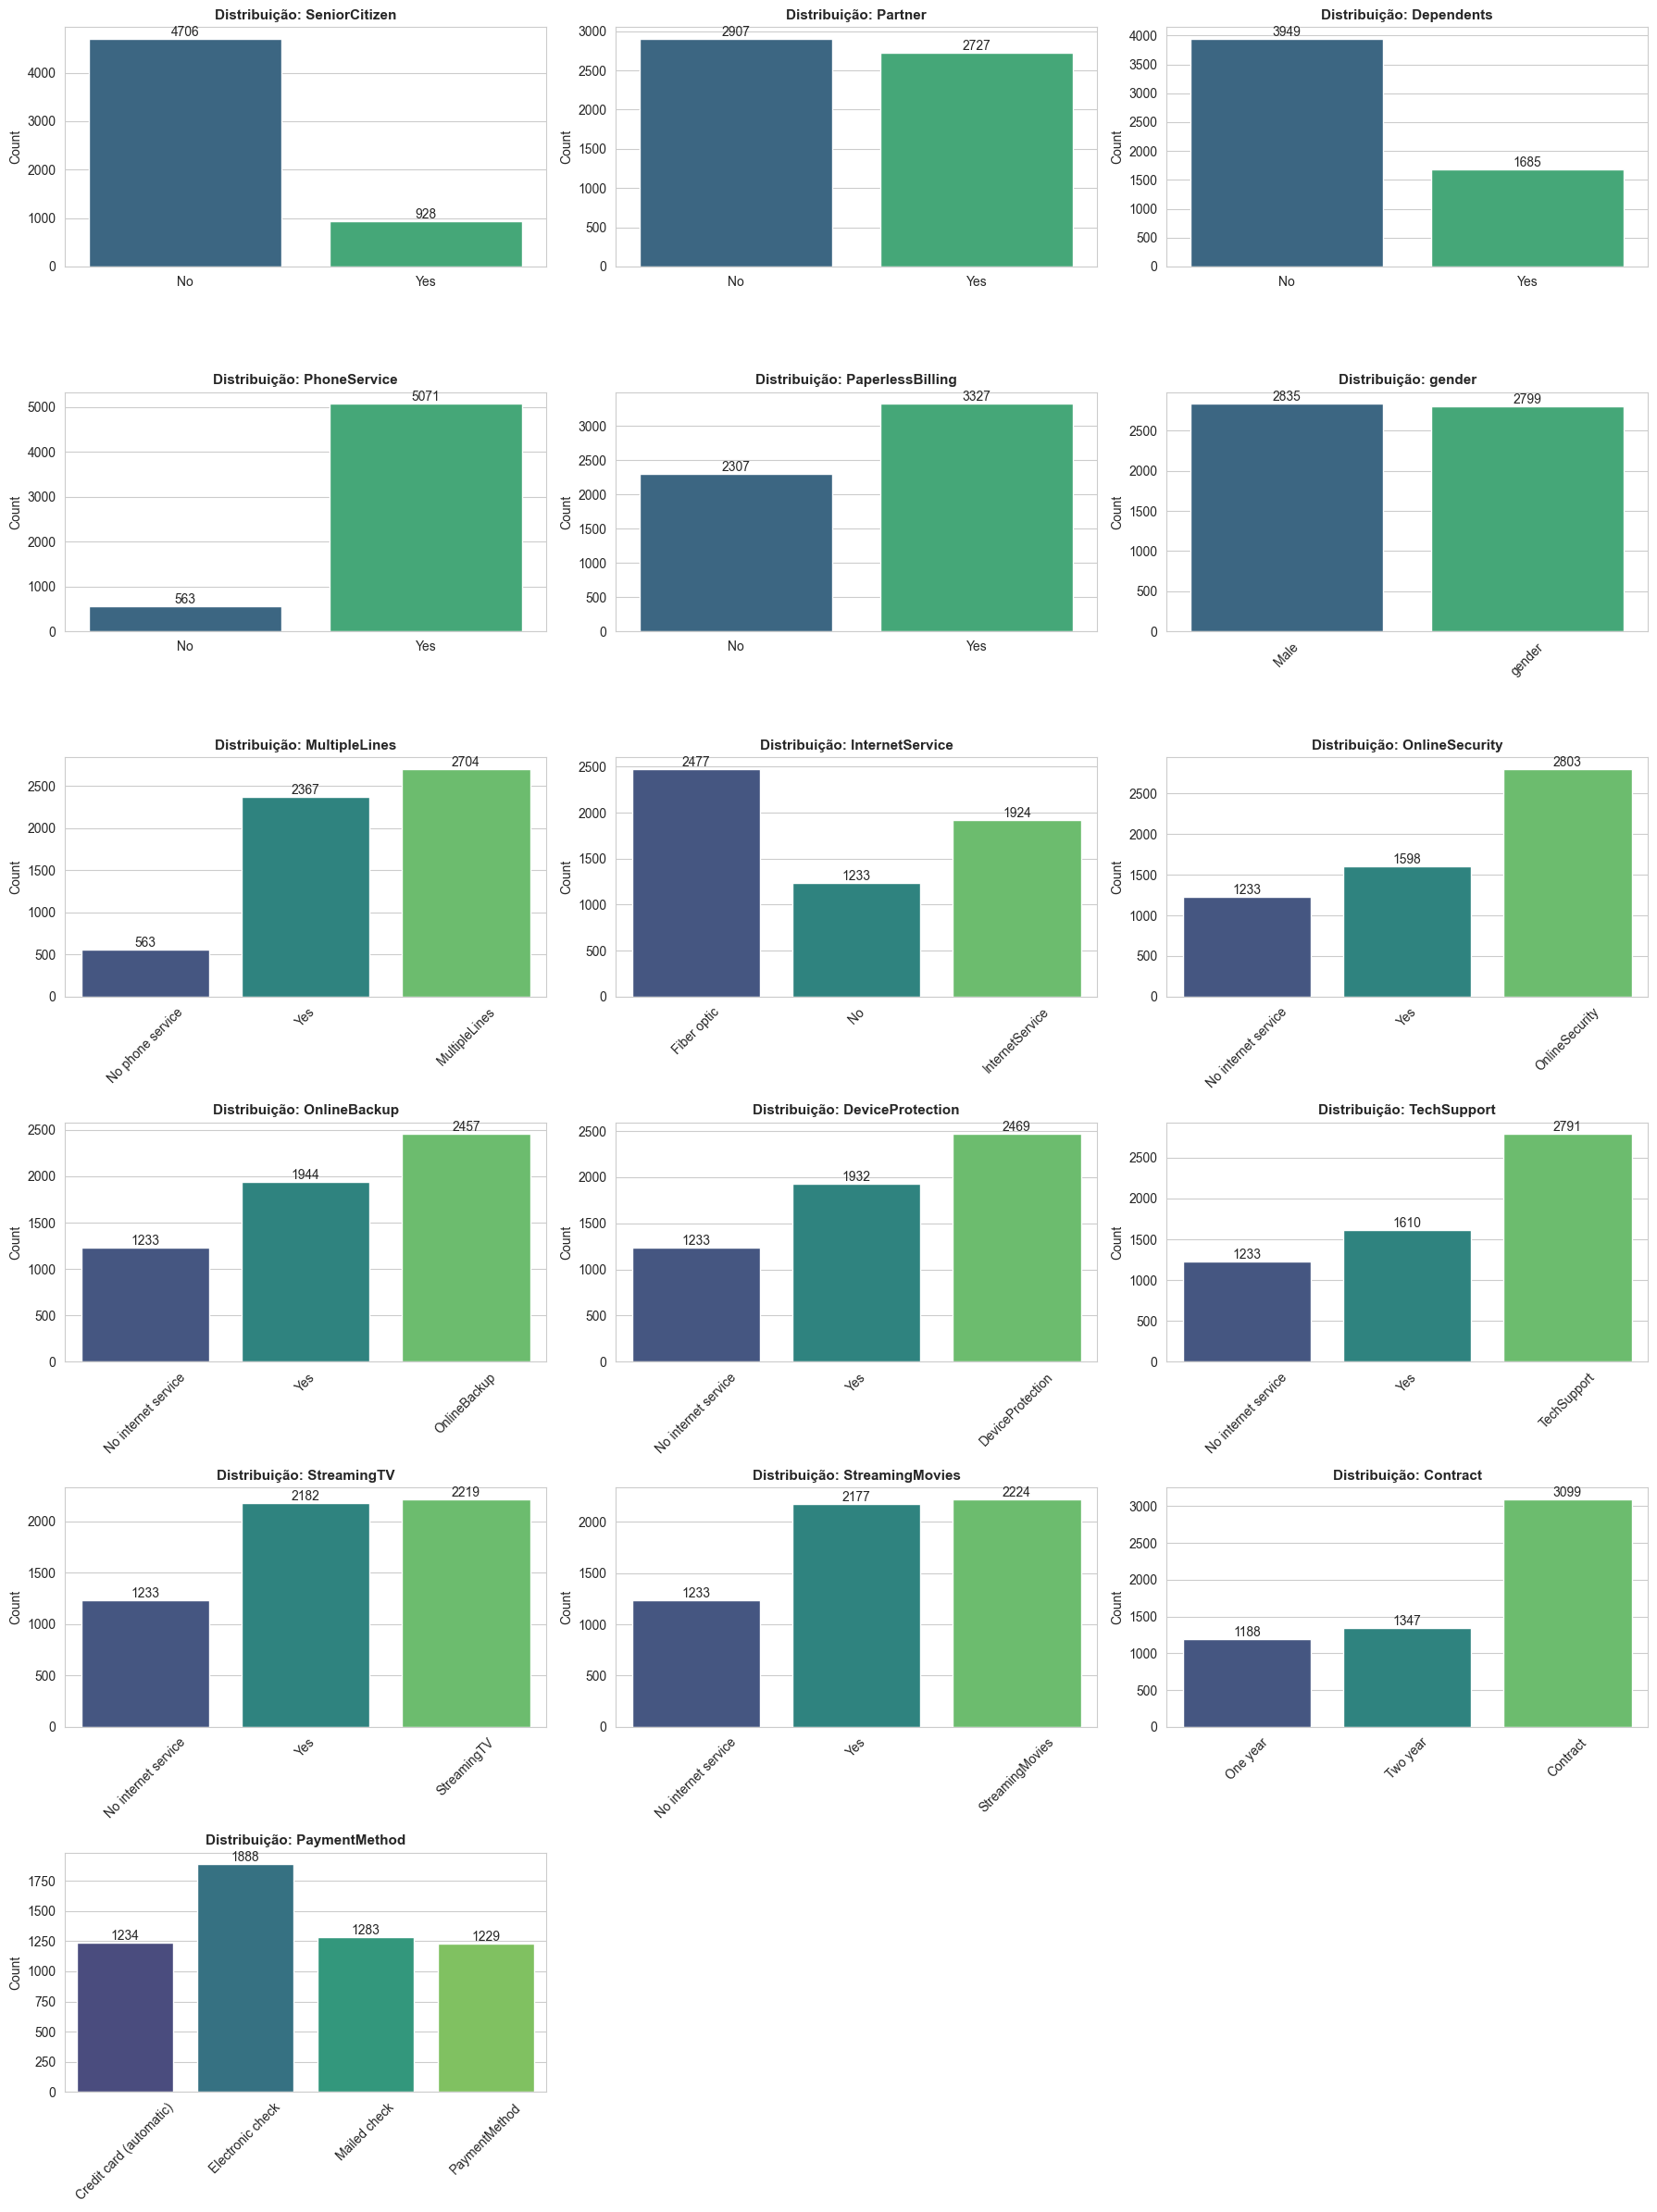

In [74]:
df = df_train_clean


print("\n ANÁLISE DE FEATURES CATEGÓRICAS:\n")


# Colunas binárias (0/1)
binary_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# Grupos de colunas one-hot encoded
onehot_groups = {
    'gender': ['gender_Male'],
    'MultipleLines': ['MultipleLines_No phone service', 'MultipleLines_Yes'],
    'InternetService': ['InternetService_Fiber optic', 'InternetService_No'],
    'OnlineSecurity': ['OnlineSecurity_No internet service', 'OnlineSecurity_Yes'],
    'OnlineBackup': ['OnlineBackup_No internet service', 'OnlineBackup_Yes'],
    'DeviceProtection': ['DeviceProtection_No internet service', 'DeviceProtection_Yes'],
    'TechSupport': ['TechSupport_No internet service', 'TechSupport_Yes'],
    'StreamingTV': ['StreamingTV_No internet service', 'StreamingTV_Yes'],
    'StreamingMovies': ['StreamingMovies_No internet service', 'StreamingMovies_Yes'],
    'Contract': ['Contract_One year', 'Contract_Two year'],
    'PaymentMethod': ['PaymentMethod_Credit card (automatic)', 
                        'PaymentMethod_Electronic check', 
                        'PaymentMethod_Mailed check']
}

# Criar subplots
total_plots = len(binary_cols) + len(onehot_groups)
n_rows = (total_plots + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.ravel()

plot_idx = 0

# Analisar colunas binárias
for col in binary_cols:
    if col in df.columns:
        value_counts = df[col].value_counts()
        
        # Mapear para labels legíveis
        labels = ['No', 'Yes']
        counts = [value_counts.get(0, 0), value_counts.get(1, 0)]
        
        # Barplot
        sns.barplot(x=labels, y=counts, palette='viridis', ax=axes[plot_idx])
        axes[plot_idx].set_title(f'Distribuição: {col}', fontsize=11, weight='bold')
        axes[plot_idx].set_ylabel('Count')
        
        # Adicionar labels
        for i, count in enumerate(counts):
            axes[plot_idx].text(i, count, str(count), ha='center', va='bottom')
        
        # Estatísticas
        print(f"\n{col}:")
        total = sum(counts)
        for label, count in zip(labels, counts):
            pct = (count / total * 100) if total > 0 else 0
            print(f"  {label:25s}: {count:5d} ({pct:5.2f}%)")
        
        plot_idx += 1

# Analisar grupos one-hot encoded
for group_name, group_cols in onehot_groups.items():
    # Verificar quais colunas existem
    existing_cols = [col for col in group_cols if col in df.columns]
    
    if existing_cols:
        # Contar valores
        categories = {}
        
        # Base category (todas as colunas são False)
        base_name = group_name.split('_')[0] if '_' in group_name else group_name
        base_count = len(df)
        
        for col in existing_cols:
            count = df[col].sum()
            # Extrair nome da categoria
            cat_name = col.replace(f"{base_name}_", "").replace(f"{group_name}_", "")
            categories[cat_name] = count
            base_count -= count
        
        # Adicionar categoria base
        if base_count > 0:
            categories[base_name] = base_count
        
        # Plotar
        if categories:
            cats = list(categories.keys())
            counts = list(categories.values())
            
            sns.barplot(x=cats, y=counts, palette='viridis', ax=axes[plot_idx])
            axes[plot_idx].set_title(f'Distribuição: {group_name}', fontsize=11, weight='bold')
            axes[plot_idx].set_ylabel('Count')
            axes[plot_idx].tick_params(axis='x', rotation=45)
            
            # Adicionar labels
            for i, count in enumerate(counts):
                axes[plot_idx].text(i, count, str(int(count)), ha='center', va='bottom')
            
            # Estatísticas
            print(f"\n{group_name}:")
            total = sum(counts)
            for cat, count in categories.items():
                pct = (count / total * 100) if total > 0 else 0
                print(f"  {cat:25s}: {int(count):5d} ({pct:5.2f}%)")
            
            plot_idx += 1

# Remover axes extras
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## 8. EDA - Análise Bivariada (Numéricas vs Churn)


tenure:
Mann-Whitney U test: p-value = 0.0000 (SIGNIFICATIVA )

MonthlyCharges:
Mann-Whitney U test: p-value = 0.0000 (SIGNIFICATIVA )

TotalCharges:
Mann-Whitney U test: p-value = 0.0000 (SIGNIFICATIVA )

MonthlyIncome:
Mann-Whitney U test: p-value = 0.3084 (NÃO SIGNIFICATIVA)


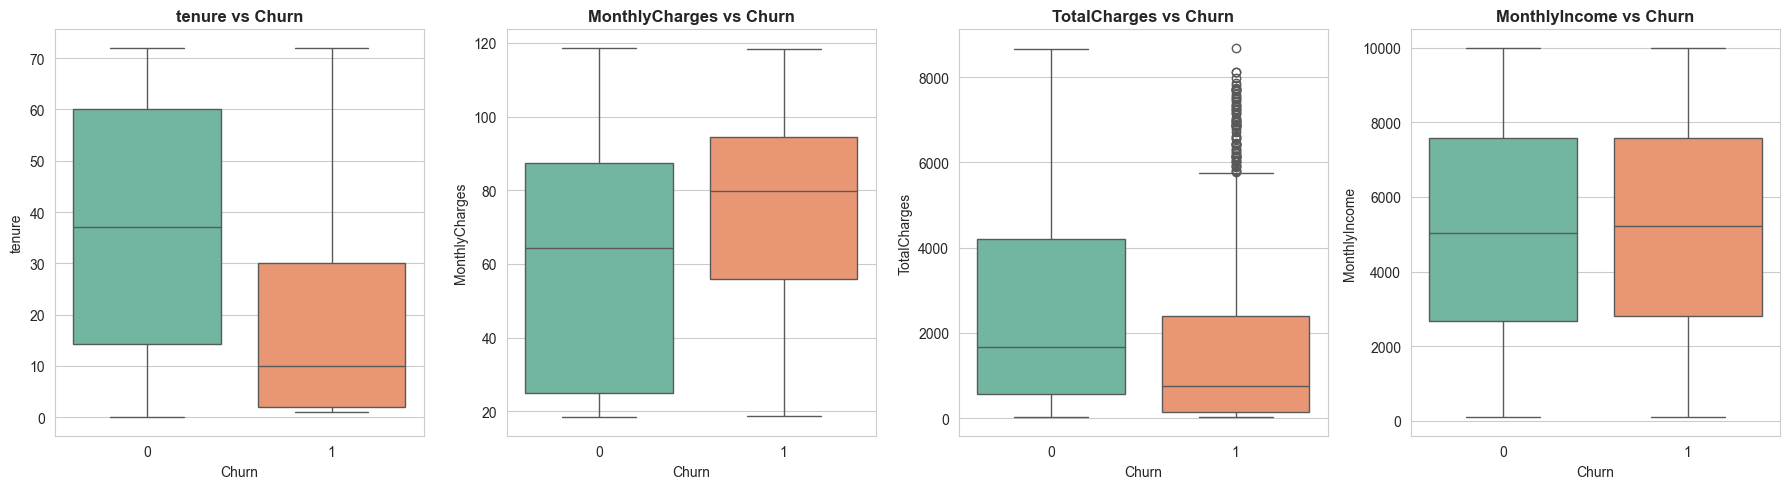


 Distribuições (KDE):


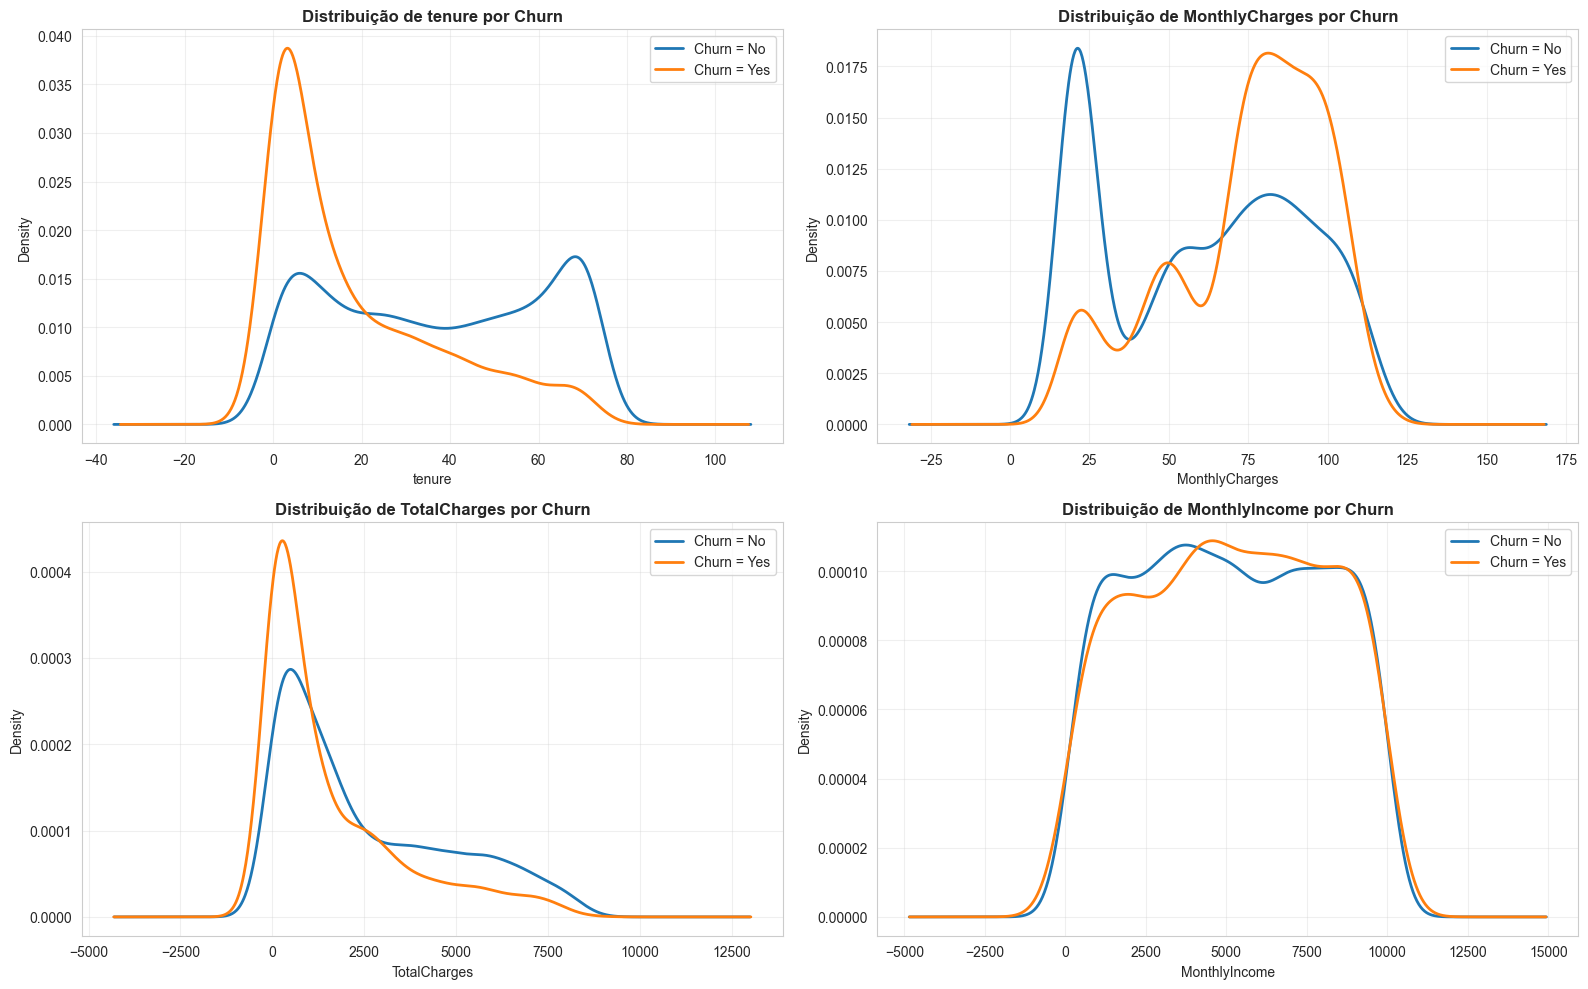

In [75]:
df = df_train_clean

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyIncome']

# Boxplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} vs Churn', weight='bold')
    
    # Teste T ou Mann-Whitney
    no_churn = df[df['Churn'] == 0][col].dropna()
    yes_churn = df[df['Churn'] == 1][col].dropna()
    
    print(f"\n{col}:")
    if len(no_churn) > 0 and len(yes_churn) > 0:
        statistic, p_value = mannwhitneyu(no_churn, yes_churn)
        significance = "SIGNIFICATIVA " if p_value < 0.05 else "NÃO SIGNIFICATIVA"
        print(f"Mann-Whitney U test: p-value = {p_value:.4f} ({significance})")
    else:
        print("Dados insuficientes para teste estatístico")

plt.tight_layout()
plt.show()

# Distribuições sobrepostas (KDE)
# Usar try-except ou checks para evitar erro de array vazio
print("\n Distribuições (KDE):")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    has_data = False
    for churn_label, churn_val in [('No', 0), ('Yes', 1)]:
        subset = df[df['Churn'] == churn_val][col].dropna()
        if len(subset) > 1 and subset.nunique() > 1:
            try:
                subset.plot(kind='kde', ax=axes[i], label=f'Churn = {churn_label}', linewidth=2)
                has_data = True
            except Exception as e:
                print(f"  Erro ao plotar KDE para {col} (Churn={churn_label}): {e}")
        else:
            # Fallback para histograma se KDE falhar ou dados insuficientes
            if len(subset) > 0:
                axes[i].hist(subset, alpha=0.5, density=True, label=f'Churn = {churn_label} (Hist)')
                has_data = True
    
    axes[i].set_title(f'Distribuição de {col} por Churn', fontsize=12, weight='bold')
    axes[i].set_xlabel(col)
    if has_data:
        axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. EDA - Análise Bivariada (Categóricas vs Churn)

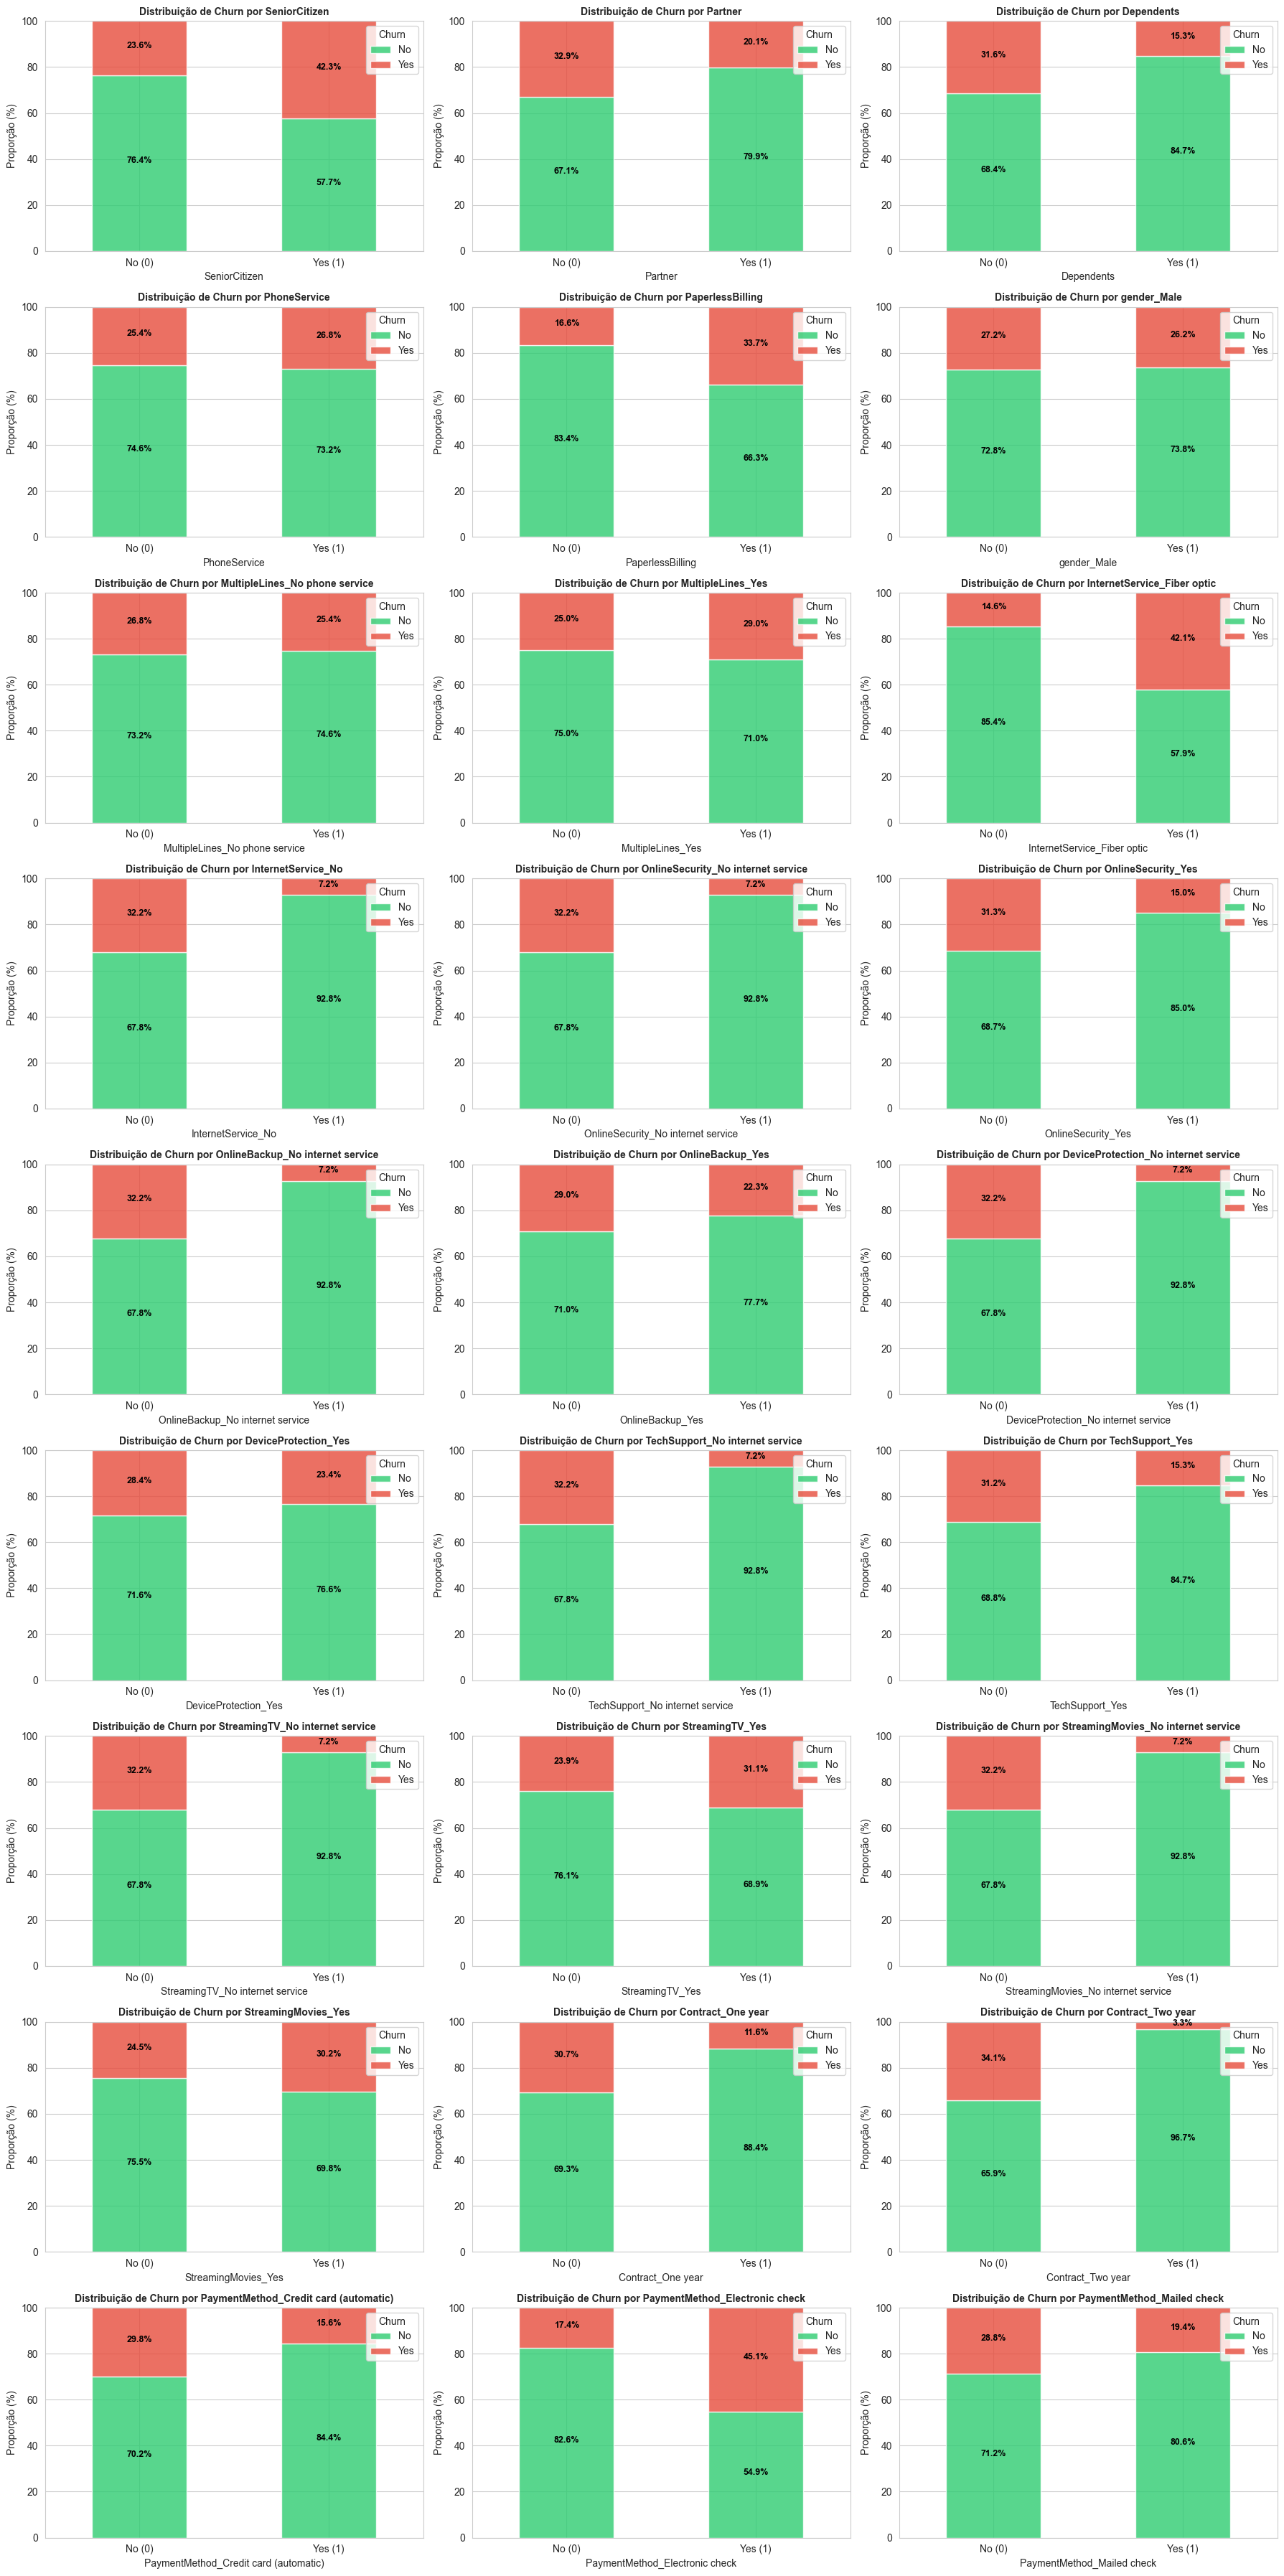

In [76]:
df = df_train_clean

binary_cols = [col for col in df.columns 
                if df[col].nunique() == 2 
                and set(df[col].unique()).issubset({0, 1})
                and col != 'Churn']

n_cols = 3
n_rows = (len(binary_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.ravel()

for i, col in enumerate(binary_cols):
    # Cria uma tabela cruzada normalizada por índice (linha) para somar 100%
    crosstab = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    
    # Plot empilhado
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], color=['#2ecc71', '#e74c3c'], alpha=0.8)
    
    axes[i].set_title(f'Distribuição de Churn por {col}', fontsize=10, weight='bold')
    axes[i].set_ylabel('Proporção (%)')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
    axes[i].legend(title='Churn', labels=['No', 'Yes'], loc='upper right')
    axes[i].set_ylim(0, 100)
    
    # Anotar as barras
    for n, x in enumerate([*crosstab.index.values]):
        for (proportion, y_loc) in zip(crosstab.loc[x], crosstab.loc[x].cumsum()):
            axes[i].text(x=n, y=(y_loc - proportion) + (proportion / 2),
                            s=f'{proportion:.1f}%', 
                            color="black", fontsize=9, fontweight="bold", ha='center')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




## 10. EDA - Matriz de Correlação

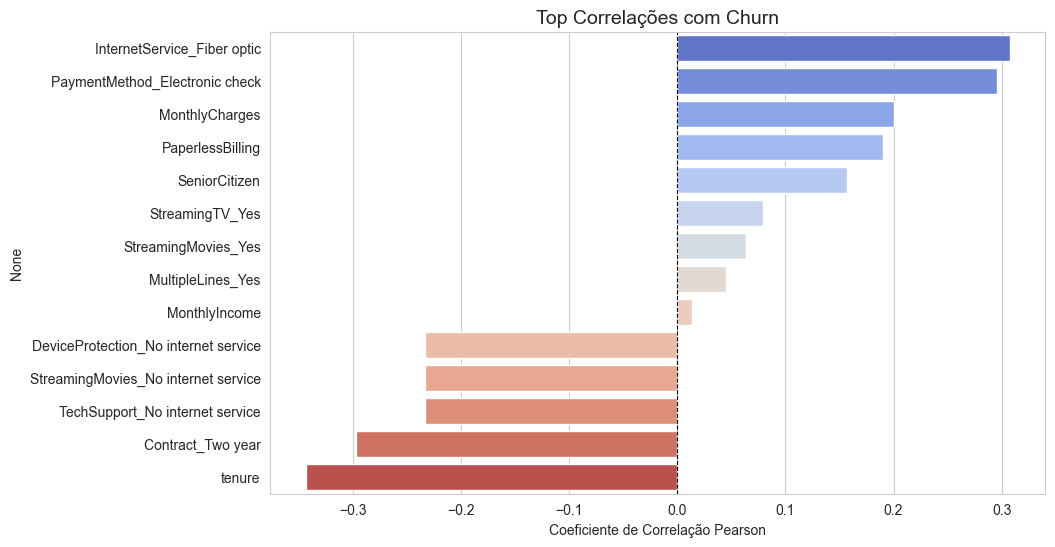

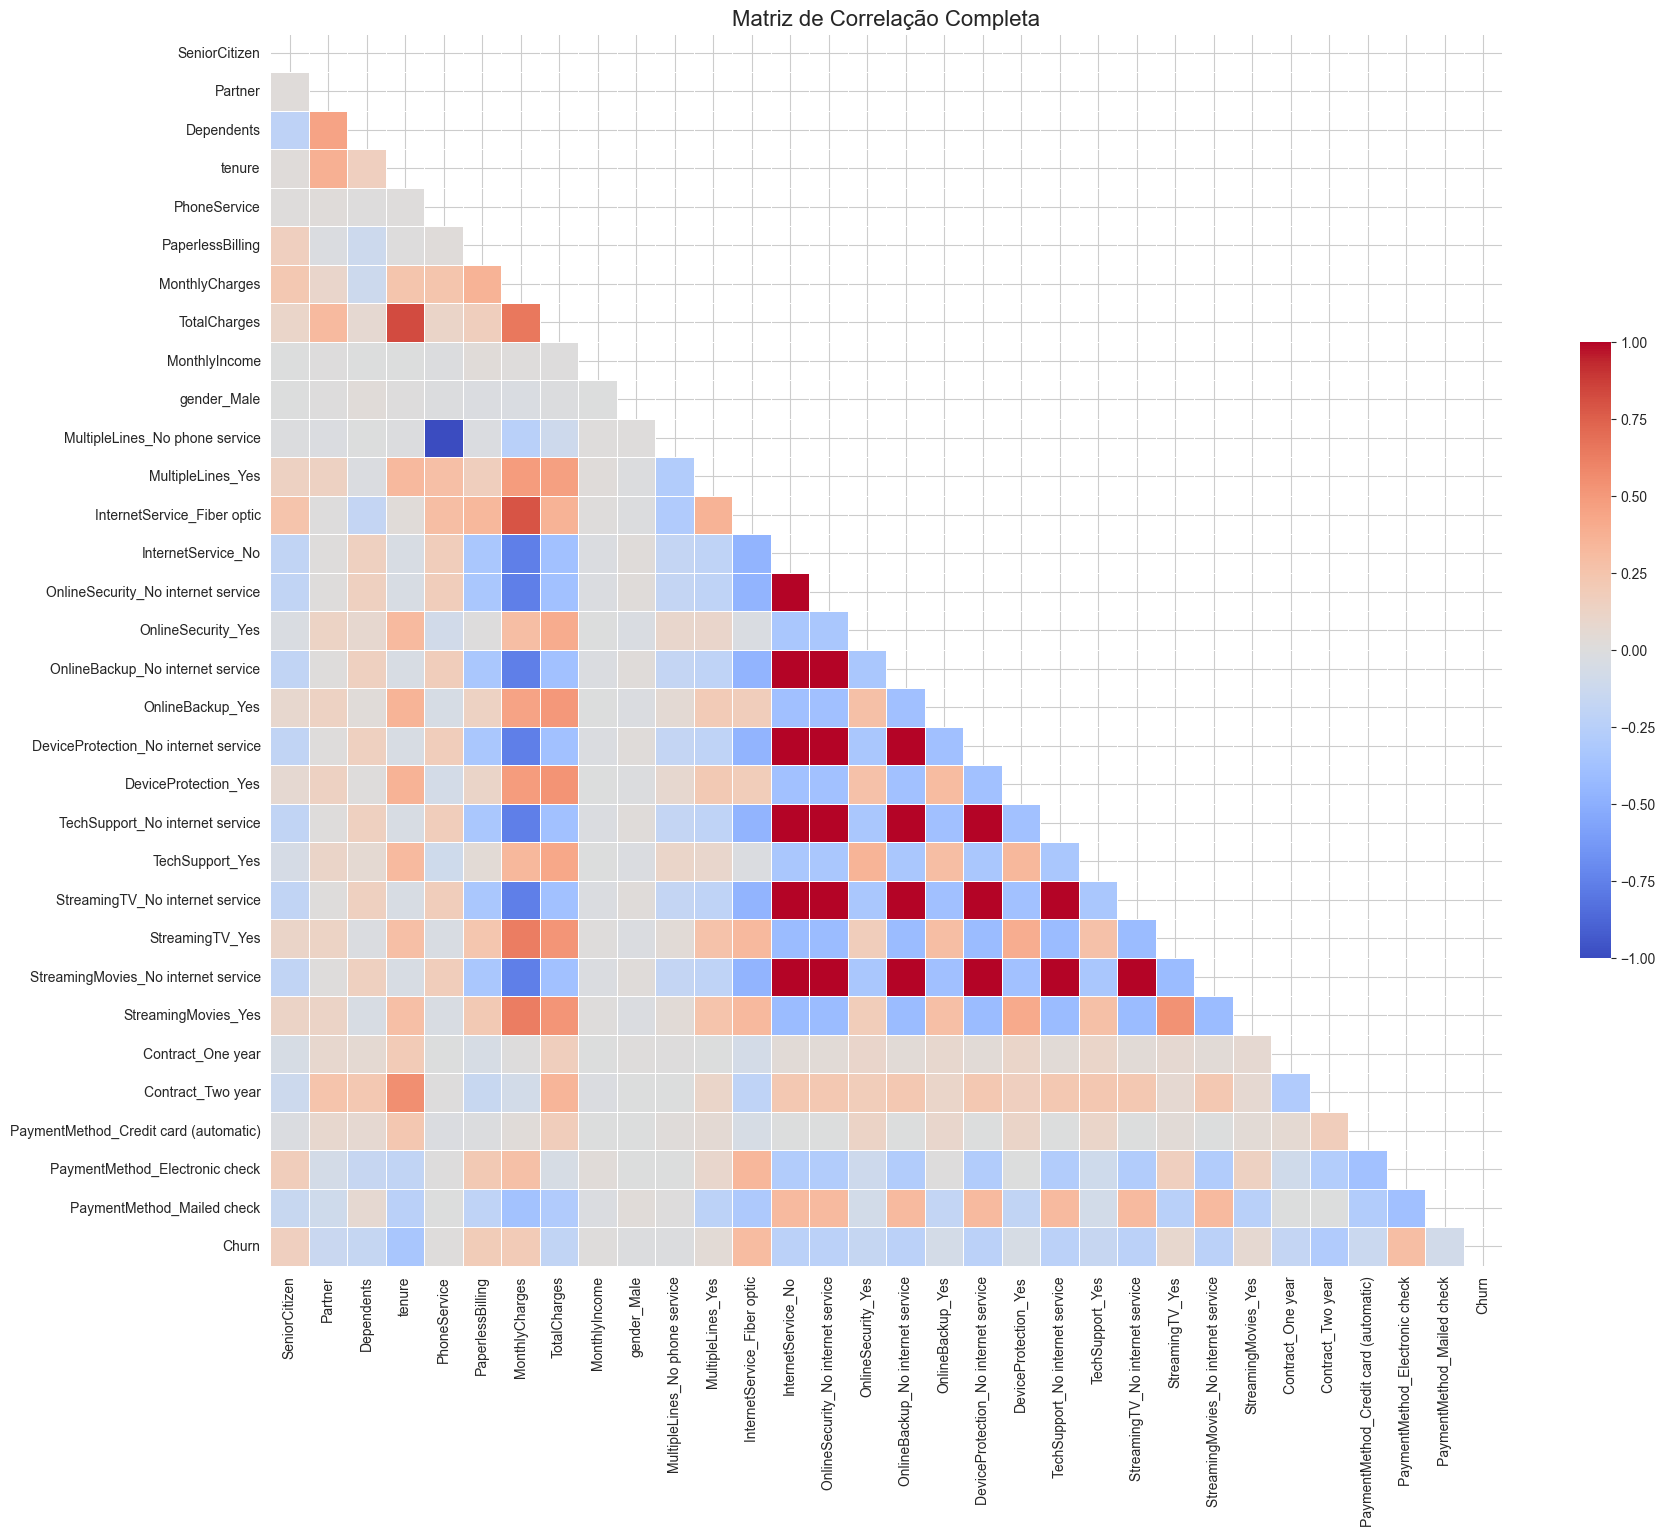

In [77]:
df = df_train_clean

# Selecionar todas as features numéricas (agora tudo é numérico)
# Remove customerID se existir
cols = [c for c in df.columns if c not in ['customerID', 'CustomerFeedback']]
df_corr = df[cols]

# Calcular correlação
corr_matrix = df_corr.corr()

# Filtrar apenas correlações com o Target (Churn)
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)

# Plot das 15 maiores correlações (positivas e negativas)
top_corr = pd.concat([churn_corr.head(10), churn_corr.tail(5)])
top_corr = top_corr[top_corr.index != 'Churn'] # Remove auto-correlação

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top Correlações com Churn', fontsize=14)
plt.xlabel('Coeficiente de Correlação Pearson')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.show()

# Heatmap completo (opcional, pode ser grande)
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=1, vmin=-1)
plt.title('Matriz de Correlação Completa', fontsize=16)
plt.show()



## 11. EDA - Análise NLP (Customer Feedback)


 ANÁLISE DE CUSTOMER FEEDBACK\n

 Comprimento do Feedback:
       feedback_length  feedback_word_count
count       5634.00000          5634.000000
mean         460.21246            79.293397
std           67.87183            11.072169
min          277.00000            49.000000
25%          414.00000            72.000000
50%          454.00000            78.000000
75%          499.00000            86.000000
max          844.00000           134.000000

 Comprimento por Churn:


Churn = No:
  Média de caracteres: 447.01
  Média de palavras: 78.18

Churn = Yes:
  Média de caracteres: 496.46
  Média de palavras: 82.34


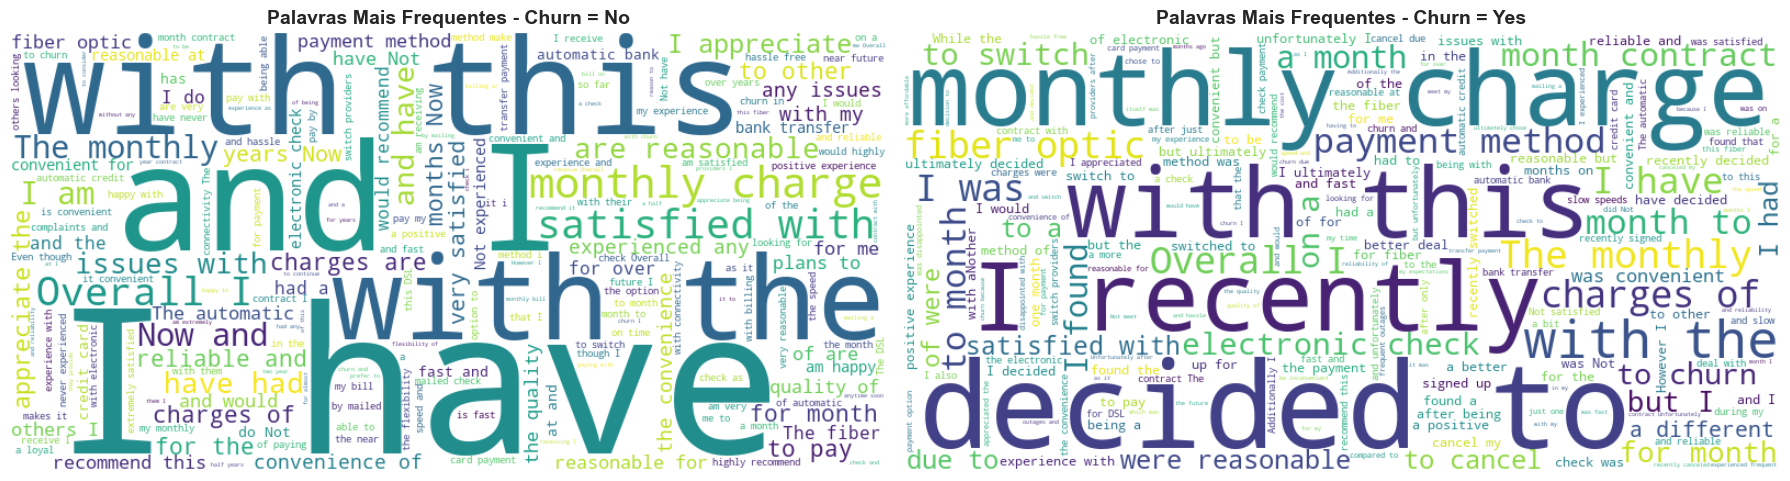


 ANÁLISE DE PALAVRAS NEGATIVAS:
                          No    Yes
has_negative_keywords              
False                  72.70  27.30
True                   73.51  26.49


In [84]:
df = df_train_clean

print("\n ANÁLISE DE CUSTOMER FEEDBACK\\n")

# Estatísticas básicas
if 'CustomerFeedback' in df.columns:
    df['feedback_length'] = df['CustomerFeedback'].astype(str).str.len()
    df['feedback_word_count'] = df['CustomerFeedback'].astype(str).str.split().str.len()
    
    print("\n Comprimento do Feedback:")
    print(df[['feedback_length', 'feedback_word_count']].describe())
    
    # Análise por grupo de Churn
    print("\n Comprimento por Churn:\n")
    for churn_value in [0, 1]:
        subset = df[df['Churn'] == churn_value]
        label = 'Yes' if churn_value == 1 else 'No'
        print(f"\nChurn = {label}:")
        if len(subset) > 0:
            print(f"  Média de caracteres: {subset['feedback_length'].mean():.2f}")
            print(f"  Média de palavras: {subset['feedback_word_count'].mean():.2f}")
        else:
            print("  Sem dados para este grupo.")
    
    # Wordcloud
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for i, churn_value in enumerate([0, 1]):
        label = 'Yes' if churn_value == 1 else 'No'
        subset_text = df[df['Churn'] == churn_value]['CustomerFeedback'].dropna().astype(str)
        text = ' '.join(subset_text)
        
        axes[i].set_title(f'Palavras Mais Frequentes - Churn = {label}', 
                            fontsize=14, weight='bold')
        
        if len(text.strip()) > 0:
            try:
                # Remover palavras comuns
                stopwords_custom = ['customer', 'company', 'internet', 'service', 'been', 'using', 'provider', 'nan', 'no', 'feedback', 'provided']
                
                wordcloud = WordCloud(width=800, height=400, 
                                        background_color='white',
                                        stopwords=stopwords_custom,
                                        colormap='viridis').generate(text)
                
                axes[i].imshow(wordcloud, interpolation='bilinear')
                axes[i].axis('off')
            except ValueError as e:
                print(f"Erro ao gerar WordCloud para Churn={label}: {e}")
                axes[i].text(0.5, 0.5, 'Erro na geração da nuvem', ha='center', va='center')
                axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, 'Sem dados suficientes', ha='center', va='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Detecção de palavras negativas
    negative_keywords = ['problem', 'issue', 'bad', 'poor', 'terrible', 
                            'worst', 'slow', 'expensive', 'cancel', 'disappointed']
    
    def has_negative_keywords(text):
        if pd.isna(text):
            return False
        text_lower = str(text).lower()
        return any(keyword in text_lower for keyword in negative_keywords)
    
    df['has_negative_keywords'] = df['CustomerFeedback'].apply(has_negative_keywords)
    
    print("\n ANÁLISE DE PALAVRAS NEGATIVAS:")

    ct = pd.crosstab(df['has_negative_keywords'], df['Churn'], normalize='index') * 100
    ct.columns = ['No', 'Yes'] if len(ct.columns) == 2 else ct.columns # Renomear colunas para label
    print(ct.round(2))

df_train_clean = df


##  12. Feature Engineering

In [90]:
def feature_engineering(df):

    df_fe = df.copy()
    
    #  Features financeiras
    df_fe['charge_income_ratio'] = df_fe['MonthlyCharges'] / df_fe['MonthlyIncome']
    df_fe['avg_monthly_spend'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1) 

    
    #  Features de tenure
    # Criar dummies para tenure group se necessário, mas aqui vamos manter numérico ou criar novas binárias
    df_fe['is_new_customer'] = (df_fe['tenure'] <= 6).astype(int)
    df_fe['is_loyal_customer'] = (df_fe['tenure'] > 60).astype(int)

    # InternetService_No (se existir)
    active_services = 0
    
    # Phone
    if 'PhoneService' in df_fe.columns:
        active_services += df_fe['PhoneService']
        
    # Internet (Contar se tem internet)
    if 'InternetService_No' in df_fe.columns:
        # Se 'No' é 0, então tem internet (1)
        active_services += (1 - df_fe['InternetService_No'])
    elif 'InternetService_Fiber optic' in df_fe.columns and 'InternetService_DSL' in df_fe.columns:
         active_services += (df_fe['InternetService_Fiber optic'] | df_fe['InternetService_DSL'])

    # Lista de serviços adicionais potenciais nas colunas OHE
    add_services = ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 
                    'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']
    
    for col in add_services:
        if col in df_fe.columns:
            active_services += df_fe[col]
            
    df_fe['total_services'] = active_services
    
    # Has Premium Tech Services
    premium_cols = ['OnlineSecurity_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes']
    premium_count = 0
    for col in premium_cols:
        if col in df_fe.columns:
            premium_count += df_fe[col]
    df_fe['has_premium_services'] = (premium_count > 0).astype(int)

    # Features contratuais
    # Ajustar para OHE
    if 'Contract_Month-to-month' in df_fe.columns:
        df_fe['is_month_to_month'] = df_fe['Contract_Month-to-month']
    elif 'Contract_One year' in df_fe.columns and 'Contract_Two year' in df_fe.columns:
        # Se Month-to-month foi dropado (base), ele é 1 quando os outros são 0
        df_fe['is_month_to_month'] = 1 - (df_fe['Contract_One year'] | df_fe['Contract_Two year'])
        
    # Electronic check might be OHE as PaymentMethod_Electronic check
    pay_col = 'PaymentMethod_Electronic check'
    if 'PaperlessBilling' in df_fe.columns and pay_col in df_fe.columns:
        df_fe['is_paperless_electronic'] = (df_fe['PaperlessBilling'] & df_fe[pay_col]).astype(int)
    
    # Features de feedback
    if 'CustomerFeedback' in df_fe.columns:
        df_fe['feedback_length'] = df_fe['CustomerFeedback'].str.len().fillna(0)
        
        negative_keywords = ['problem', 'issue', 'bad', 'poor', 'terrible', 'worst', 'slow', 'fail']
        df_fe['has_negative_keywords'] = df_fe['CustomerFeedback'].apply(
            lambda x: 1 if (pd.notna(x) and any(k in str(x).lower() for k in negative_keywords)) else 0
        )
    

    print(f"   Shape final: {df_fe.shape}")
    
    return df_fe

df_train_fe = feature_engineering(df_train_clean)
df_inference_fe = feature_engineering(df_inference_clean)


   Shape final: (5634, 45)
   Shape final: (1409, 43)


In [80]:
df_train_fe.head().transpose()

,0,1,2,3,4
customerID,4578-PHJYZ,6289-CPNLD,2682-KEVRP,5697-GOMBF,9717-QEBGU
SeniorCitizen,0,0,1,1,0
Partner,1,1,0,1,0
Dependents,1,1,0,1,0
tenure,52.0,33.0,22.0,28.0,2.0
PhoneService,1,1,1,0,1
PaperlessBilling,1,1,1,1,1
MonthlyCharges,68.75,73.9,20.05,35.9,70.3
TotalCharges,3482.85,2405.05,417.0,973.65,144.0
MonthlyIncome,6532,7634,3628,7851,1691


## 13. Salvar Dados Processados

In [ ]:
df_train=df_train_fe
df_inference=df_inference_fe


df_train.to_csv('history_fe.csv', index=False)
df_inference.to_csv('inference_fe.csv', index=False)

print(f" Arquivo salvo: history_fe.csv ({df_train.shape})")
print(f" Arquivo salvo: inference_fe.csv ({df_inference.shape})")


 Arquivo salvo: history_fe.csv ((5634, 45))
 Arquivo salvo: inference_fe.csv ((1409, 43))


## 14. Resumo Executivo de Insights

In [100]:
df = df_train_fe



# Garantir churn numérico ou booleano
if df['Churn'].dtype == 'object':
    churn_numeric = (df['Churn'] == 'Yes').astype(int)
    churn_is_yes = (df['Churn'] == 'Yes')
else:
    churn_numeric = df['Churn'].astype(int)
    churn_is_yes = (df['Churn'] == 1)
    
total_customers = len(df)
churn_rate = churn_numeric.mean() * 100

print(f"\nMÉTRICAS PRINCIPAIS:\n")

print(f"Total de clientes: {total_customers:,}")
print(f"Taxa de Churn: {churn_rate:.2f}%")
print(f"Clientes perdidos: {churn_numeric.sum():,}")

if 'MonthlyCharges' in df.columns:
    risk_revenue = df[churn_is_yes]['MonthlyCharges'].sum()
    print(f"Receita mensal em risco: ${risk_revenue:,.2f}")

print(f"\n PRINCIPAIS DRIVERS DE CHURN (Análise Simplificada em OHE):")

# Helper para calcular churn rate em colunas binárias
def print_binary_churn(col_name, display_name):
    if col_name in df.columns:
        subset_indices = df[df[col_name] == 1].index
        if len(subset_indices) > 0:
            rate = churn_numeric.loc[subset_indices].mean() * 100
            print(f"   {display_name:35s}: {rate:5.2f}% de churn")

# 1. Contratos
print("\n1. Por Tipo de Contrato (se disponível):")
# Tentar reconstruir ou usar OHE
print_binary_churn('Contract_Month-to-month', 'Month-to-month')
print_binary_churn('is_month_to_month', 'Month-to-month (Derived)')
print_binary_churn('Contract_One year', 'One year')
print_binary_churn('Contract_Two year', 'Two year')

# Se 'Contract' original existir
if 'Contract' in df.columns:
    for contract in df['Contract'].unique():
            mask = (df['Contract'] == contract)
            rate = churn_numeric[mask].mean() * 100
            print(f"   [Original] {contract:24s}: {rate:5.2f}% de churn")

# 2. Internet
print("\n2. Por Serviço de Internet:")
print_binary_churn('InternetService_Fiber optic', 'Fiber optic')
print_binary_churn('InternetService_DSL', 'DSL')
print_binary_churn('InternetService_No', 'No Internet')

# 3. Tenure
print("\n3. Tenure (Média de meses):")
if 'tenure' in df.columns:
    t_no = df[~churn_is_yes]['tenure'].mean()
    t_yes = df[churn_is_yes]['tenure'].mean()
    print(f"   Retidos (Churn=No/0): {t_no:.1f} meses")
    print(f"   Perdidos (Churn=Yes/1): {t_yes:.1f} meses")

# 4. Pagamento
print("\n4. Método de Pagamento (Electronic Check):")
print_binary_churn('PaymentMethod_Electronic check', 'Electronic check')





MÉTRICAS PRINCIPAIS:

Total de clientes: 5,634
Taxa de Churn: 26.70%
Clientes perdidos: 1,504
Receita mensal em risco: $112,242.90

 PRINCIPAIS DRIVERS DE CHURN (Análise Simplificada em OHE):

1. Por Tipo de Contrato (se disponível):
   Month-to-month (Derived)           : 42.66% de churn
   One year                           : 11.62% de churn
   Two year                           :  3.27% de churn

2. Por Serviço de Internet:
   Fiber optic                        : 42.07% de churn
   No Internet                        :  7.22% de churn

3. Tenure (Média de meses):
   Retidos (Churn=No/0): 37.4 meses
   Perdidos (Churn=Yes/1): 18.4 meses

4. Método de Pagamento (Electronic Check):
   Electronic check                   : 45.13% de churn
